In [1]:
import warnings
warnings.filterwarnings('ignore')

<h1 style = "fontsize:400%;text-align:center;">QBUS3850: Time Series and Forecasting</h1>
<h2 style = "fontsize:300%;text-align:center;">ARCH</h2>
<h3 style = "fontsize:200%;text-align:center;">Lecture Notes</h3>

<h2 style = "fontsize:300%;text-align:center;">Financial Returns Data</h2>

# Returns data

- Construct daily log returns for Rio Tinto, an large mining company.

In [2]:
import pandas as pd
import numpy as np
rio = pd.read_csv('RIO.AX.csv')
rio['Date'] = pd.to_datetime(rio['Date'])
ret=np.log(rio['Close']).diff()
print(ret.head())

0         NaN
1   -0.014536
2   -0.009457
3   -0.005824
4    0.000885
Name: Close, dtype: float64


# Heavy tails

- Financial returns tend to have heavier tails that a normal distribution would imply.
- For example the excess kurtosis here is greater than 0.
- This has been known since at least the paper of Mandelbrot in 1963.

1.7479186534350966

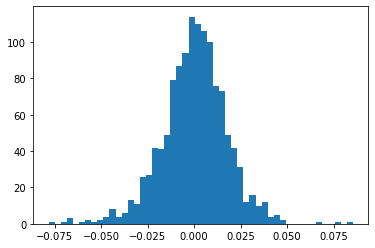

In [3]:
import matplotlib.pyplot as plt
plt.hist(ret,bins=50)
from scipy.stats import norm, kurtosis
kurtosis(ret[1:])

# Volatility clustering

- A line plot of returns data shows that volatile periods cluster together.

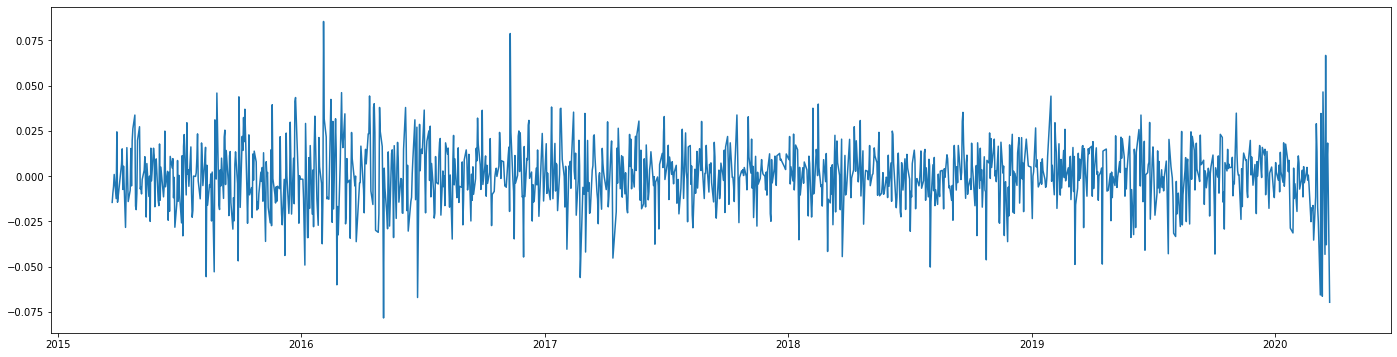

In [4]:
fig, ax = plt.subplots(1,figsize=(24,6))
ax.plot(rio['Date'],ret)

<h2 style = "fontsize:300%;text-align:center;">ARCH Model</h2>

# ARCH model

- The Auto Regressive Conditional Heteroskedasticity (ARCH) model can explain two stylised facts about returns
  - Volatility Clustering
  - Heavy tails
- It can be combined with any process for the expected value (e.g. a ARMA, regression model etc.). Let our returns data be given by
$$r_t=\mu_t+u_t$$
- for simplicity, for now focus on the *demeaned* process $u_t$ 

# ARCH(p) model

- The ARCH process is given by

$$\begin{aligned}u_t&=\sigma_t\epsilon_t\quad\epsilon_t\overset{i.i.d}{\sim}(0,1)\\\sigma^2_t&=\alpha_0+\alpha_1u^2_{t-1}+\alpha_2u^2_{t-2}+\dots+\alpha_pu^2_{t-p}\end{aligned}$$

- An alternative way to write the second equation makes the name of the model clearer.

$$E(u^2_t|u^2_{t-1},\dots,u^2_{t-p})=\alpha_0+\alpha_1u^2_{t-1}+\alpha_2u^2_{t-2}+\dots+\alpha_pu^2_{t-p}$$

# Expected value

- The expected value is 0. 
- To derive this use law of iterated expectations ($E_x(X)=E_y[E_{x|y}(X|Y)]$). In our case x is $u_t$ and y is $\mathcal{F}_{t-1}=(u_{t-1},u_{t-2},\dots)$

$$\begin{aligned}E(u_t)&=E(\sigma_t\epsilon_t)\\&=E_{\mathcal{F}_{t-1}}\left[E_{u_t|\mathcal{F}_{t-1}}[\color{blue}{\sigma_t}\epsilon_t|\mathcal{F}_{t-1}]\right]\\&=E_{\mathcal{F}_{t-1}}\left[\color{blue}{\sigma_t}\color{red}{[E_{u_t|\mathcal{F}_{t-1}}[\epsilon_t]}\right]\\&=E_{\mathcal{F}_{t-1}}\left[\color{blue}{\sigma_t}\color{red}{0}\right]=0\end{aligned}$$

# Variance of ARCH(1)

$$\begin{aligned}E(u^2_t)&=E(\sigma^2_t\epsilon^2_t)\\&=E_{\mathcal{F}_{t-1}}\left[E_{u_t|\mathcal{F}_{t-1}}[\color{blue}{\sigma^2_t}\epsilon^2_t|\mathcal{F}_{t-1}]\right]\\&=E_{\mathcal{F}_{t-1}}\left[\color{blue}{\sigma^2_t}\color{red}{[E_{u_t|\mathcal{F}_{t-1}}[\epsilon^2_t]}\right]\\&=E_{\mathcal{F}_{t-1}}\left[\color{blue}{\sigma^2_t}\color{red}{\times 1}\right]\\&=E_{\mathcal{F}_{t-1}}\left[\alpha_0+\alpha_1u^2_{t-1}\right]\\&=\alpha_0+\alpha_1E_{\mathcal{F}_{t-1}}\left[u^2_{t-1}\right]\end{aligned}$$

# Stationarity

Note for a stationary ARCH $E(u^2_t)=E(u^2_{t-1})$ meaning we can write

$$\begin{aligned}E(u_t^2)&=\alpha_0+\alpha_1E(u^2_{t-1})\\&=\alpha_0+\alpha_1E(u^2_{t})\\&=\frac{\alpha_0}{1-\alpha_1}\end{aligned}$$

It makes sense to constrain $\alpha_0>0$ and $\alpha_1<1$ to ensure a positive (unconditional) variance. It is also common to constrain $\alpha_1\geq0$ to guarantee positive (conditional) variance.

# Conditional v Unconditional

- Doesn't the fact we have $\sigma_t$ make it non-stationary???
- NO!
- Remember the difference between conditional and unconditional moments.
- The conditional variance changes over time.
- The unconditional variance can be constant.

# Simulation

- Simulate from an ARCH(1) with $\alpha_0=0.6$ and $\alpha_1=0.7$. Unconditional variance should be 2. Try yourselves before viewing the next slide.

In [5]:
T=2000
I=2000
np.random.seed(167)
sigma2t=np.zeros((I,T))
y=np.zeros((I,T))
for i in range(I):
    for t in range(1,T):
        sigma2t[i,t]=0.6+0.7*y[i,t-1]**2
        y[i,t]=np.sqrt(sigma2t[i,t])*np.random.standard_normal(size=1) 


# Stylised features

- Line plot and histogram of first simulated series

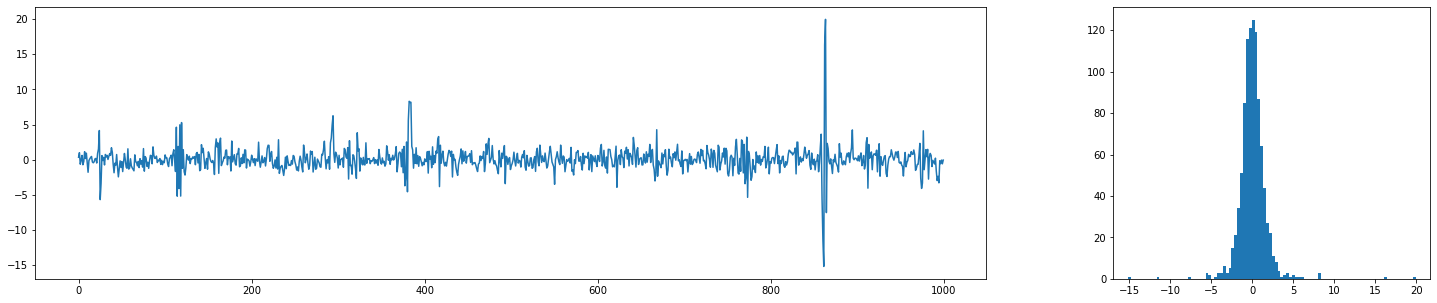

In [6]:
fig,ax = plt.subplots(1,2,figsize=(25,5),gridspec_kw={'width_ratios': [3, 1]})  
ax[0].plot(np.arange(1000),y[1,1000:])
ax[1].hist(y[1,1000:],bins = 100)
fig.show()

# Conditional v Unconditional

- Top is conditional variance (for 5 realisations), bottom is (approx.) unconditional variance.

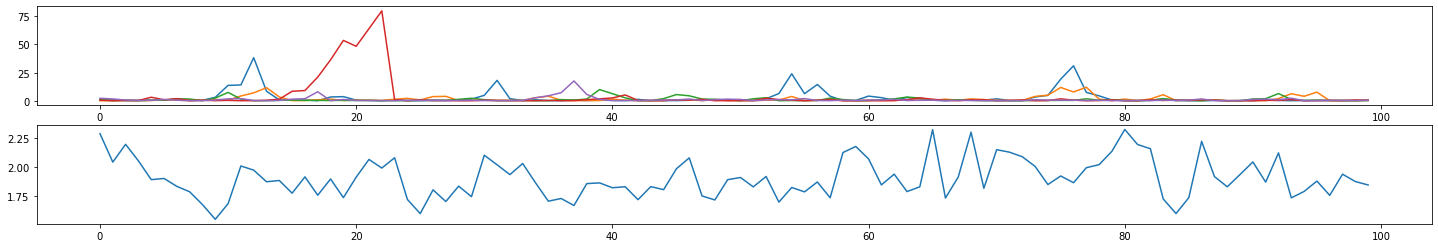

In [7]:
y=y[:,1900:]
sigma2t=sigma2t[:,1900:]
uncondvar = np.var(y,axis=0)
fig,ax=plt.subplots(2,1,figsize=(25,4))
for i in range(5):
    ax[0].plot(np.arange(100),sigma2t[i,:])
ax[1].plot(np.arange(100),uncondvar)

# Main takeaways

- The ARCH model captures two of the characteristic features of financial returns
  - Volatility clustering
  - Heavy tails (even with normal errors)
- For forecasting, it can be used to get better forecasts of the variances.
- However it is still stationary.
- Open questions
  - How to estimate an ARCH model?
  - How to test whether the model is well specified?
  

<h2 style = "fontsize:300%;text-align:center;">Estiating ARCH</h2>

# Maximum Likelihood

- To estimate the parameters MLE can be used.
- The likelihood can be built as follows

$$p(u_t,u_{t-1},\dots,u_1;\boldsymbol{\alpha}) = p(u_t|\mathcal{F_{t-1}})p(u_{t-1}|\mathcal{F_{t-2}})\dots $$

- Here $\boldsymbol{\alpha}$ is all the parameters.
- First what does $p(u_t|\mathcal{F_{t-1}})$

# One term

For a single term in the likelihood consider

$$u_t|\mathcal{F}_{t-1}\sim N(0,\sigma_t)$$

This has a density

$$p(u_t|\mathcal{F}_{t-1}) = (2\pi\sigma_t)^{-1/2}\exp\left\{-\frac{u_t^2}{2\sigma_t}\right\}$$

Substituting in $\sigma_t=\alpha_0+\alpha_1u_{t-1}+\dots+\alpha_pu_{t-p}$ gives

$$p(u_t|\mathcal{F}_{t-1}) = (2\pi(\color{blue}{\alpha_0+\alpha_1u_{t-1}+\dots+\alpha_pu_{t-p}}))^{-1/2}\exp\left\{-\frac{u_t^2}{2(\color{blue}{\alpha_0+\alpha_1u_{t-1}+\dots+\alpha_pu_{t-p}})}\right\}$$

# Initial values

- This works up until $t=p$. For example for an ARCH(1)

$$p(u_t,u_{t-1},\dots,u_1;\boldsymbol{\alpha}) = p(u_t|\mathcal{u_{t-1}})p(u_{t-1}|\mathcal{u_{t-2}})\dots 
p(u_2|u_{1})p(u_1) $$

What do you think should be done with $p(u_1)$?

# Two alternatives

- Conditional likelihood. Ignore $p(u_1)$ and form a likelihood

$$p(u_t,u_{t-1},\dots,u_2|u_1;\boldsymbol{\alpha}) = p(u_t|\mathcal{u_{t-1}})p(u_{t-1}|\mathcal{u_{t-2}})\dots 
p(u_2|u_{1})$$

- Unconditional likelihood. For p(u_1) use the stationary distribution of $u$, i.e

$$p(u_1) = \left(2\pi\frac{\alpha_0}{1-\alpha_1}\right)^{-1/2}\exp\left\{-\frac{u_1^2}{2\frac{\alpha_0}{1-\alpha_1}}\right\}$$

- With enough data the difference between the two approaches in small.

# In Python

- Fitting an ARCH(1) to Rio Tinto data

In [8]:
from arch import arch_model
fitarch1 = arch_model( ret[1:], mean='Constant', vol='ARCH', p=1 ).fit()
print( fitarch1.summary() )

Iteration:      1,   Func. Count:      5,   Neg. LLF: 130859545439.21945
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7183.083266044059
Iteration:      3,   Func. Count:     24,   Neg. LLF: -1602.1107071194883
Iteration:      4,   Func. Count:     31,   Neg. LLF: -3325.2461990257916
Iteration:      5,   Func. Count:     36,   Neg. LLF: -3315.2004006562565
Iteration:      6,   Func. Count:     42,   Neg. LLF: -3326.4138062787147
Iteration:      7,   Func. Count:     48,   Neg. LLF: -3343.34162754509
Iteration:      8,   Func. Count:     53,   Neg. LLF: -3343.3420579222607
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3343.342058175972
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 8
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                  Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-

# Order

- Fitting an ARCH(5) to Rio Tinto data

In [9]:
fitarch5 = arch_model( ret[1:], mean='Constant', vol='ARCH', p=5 ).fit()
print( fitarch5.summary() )

Iteration:      1,   Func. Count:      9,   Neg. LLF: 92977512.62514775
Iteration:      2,   Func. Count:     24,   Neg. LLF: 160596.22285895975
Iteration:      3,   Func. Count:     34,   Neg. LLF: -3244.1732462210593
Iteration:      4,   Func. Count:     44,   Neg. LLF: -3014.1218965200455
Iteration:      5,   Func. Count:     54,   Neg. LLF: 114547612.13873027
Iteration:      6,   Func. Count:     69,   Neg. LLF: -3305.44048670388
Iteration:      7,   Func. Count:     78,   Neg. LLF: -3357.4153843578447
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3357.415384602466
            Iterations: 11
            Function evaluations: 78
            Gradient evaluations: 7
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                  Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                       ARCH   Lo

# Different mean model

- Fitting an AR(1)-ARCH(5) to Rio Tinto data

In [10]:
fitararch = arch_model( ret[1:], mean='AR', lags=1, vol='ARCH', p=5 ).fit()
print( fitararch.summary() )

Iteration:      1,   Func. Count:     10,   Neg. LLF: 94156172.32231662
Iteration:      2,   Func. Count:     26,   Neg. LLF: 878123.268259564
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3261.158677097485
Iteration:      4,   Func. Count:     49,   Neg. LLF: 8041.463752373571
Iteration:      5,   Func. Count:     64,   Neg. LLF: 530489.18050867
Iteration:      6,   Func. Count:     80,   Neg. LLF: 3460.724131226378
Iteration:      7,   Func. Count:     95,   Neg. LLF: 1640.8473503544178
Iteration:      8,   Func. Count:    109,   Neg. LLF: 12384.411012300812
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3355.160488241235
            Iterations: 12
            Function evaluations: 116
            Gradient evaluations: 8
                           AR - ARCH Model Results                            
Dep. Variable:                  Close   R-squared:                      -0.001
Mean Model:                        AR   Adj. R-squared: 

# Mean and variance forecasts

In [11]:
fc = fitararch.forecast(horizon=5)
print(fc.mean.iloc[1266:,:])
print(fc.variance.iloc[1266:,:])

           h.1       h.2       h.3       h.4       h.5
1267 -0.002705  0.000073  0.000188  0.000193  0.000193
           h.1       h.2       h.3       h.4      h.5
1267  0.001011  0.000688  0.000634  0.000823  0.00072


# Non normal distributions

- Maximum likelihood assumes a normal distribution, but alternatives can be used

In [12]:
fitararcht = arch_model( ret[1:], mean='AR', lags=1, vol='ARCH', p=5 ,dist='t').fit()
print( fitararcht.summary() )

Iteration:      1,   Func. Count:     11,   Neg. LLF: 46333.26740398592
Iteration:      2,   Func. Count:     31,   Neg. LLF: 1641.5586276742492
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1438.9456718389065
Iteration:      4,   Func. Count:     58,   Neg. LLF: 87768.40308862353
Iteration:      5,   Func. Count:     78,   Neg. LLF: 5190.599725531976
Iteration:      6,   Func. Count:     88,   Neg. LLF: 5144.989217354487
Iteration:      7,   Func. Count:     98,   Neg. LLF: 5037.391952348897
Iteration:      8,   Func. Count:    108,   Neg. LLF: 108342.41223010959
Iteration:      9,   Func. Count:    119,   Neg. LLF: 36830.993057498985
Iteration:     10,   Func. Count:    130,   Neg. LLF: 9920.626444686026
Iteration:     11,   Func. Count:    142,   Neg. LLF: 7721.705176177615
Iteration:     12,   Func. Count:    153,   Neg. LLF: 6231.146271988801
Iteration:     13,   Func. Count:    167,   Neg. LLF: 5161.224002496603
Iteration:     14,   Func. Count:    180,   Neg. LLF: 4271.8

<h2 style = "fontsize:300%;text-align:center;">Testing for ARCH effects</h2>

# Ljung Box Q-Statistic

- The Ljung Box Q-Statistic test if there is any autocorrelation in data up to order $m$. For raw data, it has test statistic

$$Q=T(T+2)\sum\limits_{k=1}^m\frac{\rho^2_k}{T-k}\sim\chi^2_{m}$$

- Null is no correlation up to order $m$ against alternative that there is autocorrelation.
- For model residuals, the degrees of freedom should be adjusted by subtracting the number of parameters estimated (excluding intercepts). For example for an AR(1)-ARCH(1) model, with $m=10$ the correct degrees of freedom is $8$.

# Using the Q stat

- The same test can be used to check both mean and variance specification.
  - To test mean specification carry out the test on residuals.
  - To test mean specification carry out the test on squared residuals.
- By residuals here, we mean the standardised residuals (i.e. residual divided by estimate of $\sigma_t$.  

# ARCH(1) model mean

- Testing all lags from 10-15

In [13]:
import statsmodels.api as sm
sres=fitarch1.std_resid
sm.stats.diagnostic.acorr_ljungbox(sres,lags=range(10,16),model_df=2,return_df=True)

,lb_stat,lb_pvalue
10,8.047941,0.428801
11,8.438992,0.490582
12,10.248085,0.419004
13,10.427445,0.492397
14,12.137991,0.434662
15,12.888243,0.456481


Mean model is well specified

# ARCH(1) model variance

In [14]:
sressq=pow(sres,2)
sm.stats.diagnostic.acorr_ljungbox(sressq,lags=range(10,16),model_df=2,return_df=True)

,lb_stat,lb_pvalue
10,62.954242,1.223207e-10
11,62.969212,3.576759e-10
12,66.065624,2.533650e-10
13,66.080445,6.745513e-10
14,86.970712,1.899968e-13
15,87.604178,4.006198e-13


Variance model is not well specified

# Your turn

- Repeat this for an ARCH(5)

# Checking distribution

- Distribution can be checked using a QQ plot.
- The QQ plot is plots the empirical quantiles against the quantiles of a normal distribution.
- If the points lie along a 45 degree line then the data come from a normal distribution.
- Do you think we should use residuals or standardised residuals?

# QQ-plot

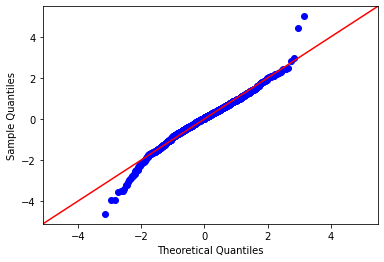

In [15]:
qq=sm.qqplot(sres,line='45')
qq.show()

Fatter left tail indicates a skew distribution may be more appropriate.

# Conclusions

- ARCH model is an autoregressive model on variance
- It yields volatility clustering and fat tails
- It can be estimated by maximum likelihood.
- Forecasts of the mean *and* variance can be obtained. 
- Models can be selected by AIC and then checked using the Q-test and QQ-plots